<center><h2><b>Markov Chain Simulation</b></h2></center>

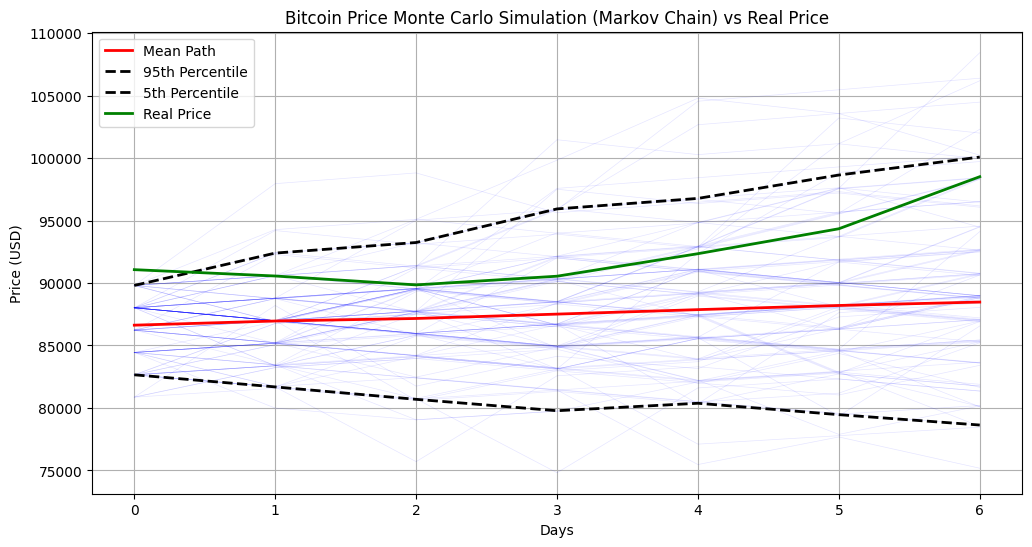

Current Price: $87,250.43
Expected Price (7 days): $88,472.74
95% Confidence Interval:
Lower Bound: $78,632.69
Upper Bound: $100,075.60

Real Final Price: $98,504.73
Prediction Error: $10,031.98
Prediction Error (%): 10.18%


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

compare_with_real_data = True

df = pd.read_csv('data/BTC-USD_2023-11-14_2024-11-15_2024-12-15.csv')

df['Returns'] = df['Close'].pct_change()

num_states = 10
bins = np.linspace(df['Returns'].min(), df['Returns'].max(), num_states + 1)

df['State'] = np.digitize(df['Returns'], bins) - 1
df['State'] = df['State'].clip(0, num_states - 1)

def calculate_transition_matrix(states, num_states):
    transition_matrix = np.zeros((num_states, num_states))
    
    for (i, j) in zip(states[:-1], states[1:]):
        transition_matrix[i, j] += 1
    
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.nan_to_num(transition_matrix)
    return transition_matrix

transition_matrix = calculate_transition_matrix(df['State'].dropna().astype(int), num_states)

num_simulations = 1000
num_days = 7
last_price = df['Close'].iloc[-1]
last_state = df['State'].iloc[-1]

simulation_results = np.zeros((num_days, num_simulations))
for sim in range(num_simulations):
    price_path = [last_price]
    current_state = last_state
    
    for day in range(num_days):
        next_state = np.random.choice(num_states, p=transition_matrix[current_state])
        simulated_return = (bins[next_state] + bins[next_state + 1]) / 2
        next_price = price_path[-1] * (1 + simulated_return)        
        price_path.append(next_price)
        current_state = next_state

    simulation_results[:, sim] = price_path[1:]

mean_path = np.mean(simulation_results, axis=1)
lower_bound = np.percentile(simulation_results, 5, axis=1)
upper_bound = np.percentile(simulation_results, 95, axis=1)

plt.figure(figsize=(12, 6))

for i in range(100):
    plt.plot(simulation_results[:, i], 'b-', alpha=0.1, linewidth=0.5)

plt.plot(mean_path, 'r-', label='Mean Path', linewidth=2)
plt.plot(upper_bound, 'k--', label='95th Percentile', linewidth=2)
plt.plot(lower_bound, 'k--', label='5th Percentile', linewidth=2)

if compare_with_real_data:
    df_real = pd.read_csv('data/BTC-USD_1mo_2024-12-15.csv')
    plt.plot(df_real['Close'].values[:num_days], 'g-', label='Real Price', linewidth=2)
    plt.title('Bitcoin Price Monte Carlo Simulation (Markov Chain) vs Real Price')
else:
    plt.title('Bitcoin Price Monte Carlo Simulation (Markov Chain)')

plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Current Price: ${last_price:,.2f}")
print(f"Expected Price ({num_days} days): ${mean_path[-1]:,.2f}")
print(f"95% Confidence Interval:")
print(f"Lower Bound: ${lower_bound[-1]:,.2f}")
print(f"Upper Bound: ${upper_bound[-1]:,.2f}")

if compare_with_real_data and len(df_real) >= num_days:
    real_final_price = df_real['Close'].iloc[num_days-1]
    print(f"\nReal Final Price: ${real_final_price:,.2f}")
    print(f"Prediction Error: ${abs(mean_path[-1] - real_final_price):,.2f}")
    print(f"Prediction Error (%): {abs(mean_path[-1] - real_final_price) / real_final_price * 100:.2f}%")
